### Task1

In [1]:
import math
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
import tqdm

/Users/denissinickij/miniforge3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [398]:
#сначала было такое решение, но за счет присутствия в решении операции деления, данный вариант не работает если в массиве есть нули
def multiplicate(a):
    b = math.prod(a)
    c = [int(b / a[i]) for i in range(len(a))]
    return c

In [399]:
def multiplicate1(a):
    c = []
    for i in range(len(a)):
        b = 1
        for j in range(len(a)):
            if j != i:
                b *= a[j]
        c.append(b)
    return c
    

In [400]:
a = [1, 2, 3, 4]
multiplicate1(a)

[24, 12, 8, 6]

### Task2 classification noisy/clean audio

In [459]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import scipy
import pathlib
import tqdm

import sklearn
from sklearn.model_selection import KFold, cross_val_score
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier



import warnings
warnings.filterwarnings('ignore')

In [417]:
clean_audio = np.load('/Users/denissinickij/Downloads/test_task/train/train/clean/20/20_205_20-205-0004.npy')
noisy_audio = np.load('/Users/denissinickij/Downloads/test_task/train/train/noisy/20/20_205_20-205-0004.npy')

In [418]:
print(len(clean_audio))
print(len(clean_audio[0]))
print(len(clean_audio)==len(noisy_audio))

875
80
True


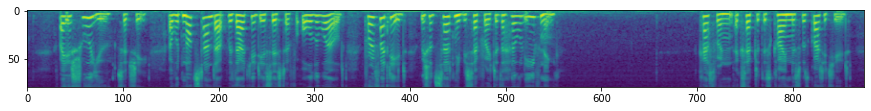

In [419]:
plt.figure(figsize=(15,5))
plt.imshow(clean_audio.T)

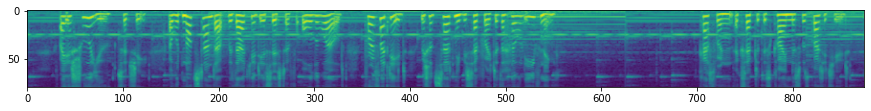

In [420]:
plt.figure(figsize=(15,5))
plt.imshow(noisy_audio.T)

In [421]:
print(np.mean(np.sum(clean_audio)))
print(np.mean(np.sum(noisy_audio)))

12040.0
18690.0


In [442]:
clean_path = '/Users/denissinickij/Downloads/test_task/train/train/clean'
noisy_path = '/Users/denissinickij/Downloads/test_task/train/train/noisy'
clean_path_val = '/Users/denissinickij/Downloads/test_task/val/val/clean'
noisy_path_val = '/Users/denissinickij/Downloads/test_task/val/val/noisy'

In [436]:
speaker_list = os.listdir(noisy_path)
speaker_val_list = os.listdir(clean_path_val)

In [ ]:
#функция для получения средних значений и стандартного отклонения из mel-спектрограмм 
def exctract_features(directory, speaker, file):
    name = f'{directory}/{speaker}/{file}'
    mel = np.load(name)
    features = []
    features.append(file)
    features.extend(np.mean(mel, axis=1)[:50])
    features.extend(np.std(mel, axis=1)[:50])
    if directory.split('/')[-1] == 'clean':
        features.append(0)
    else:
        features.append(1)
    return features

In [445]:
#функция для создания датасетов со средними значениями и стандартными отклонениями
def create_data(directory_list, speaker_list):
    
    header = ['filename']
    header.extend([f'mel_mean{i}' for i in range(1, 51)])
    header.extend([f'mel_std{i}' for i in range(1, 51)])
    header.append('class')
    df = pd.DataFrame(columns=header)
    
    for directory in directory_list:
        
        for speaker in speaker_list:
            _, _, files = next(os.walk(f'{directory}/{speaker}/'))
            for file in files:
                feature = exctract_features(directory, speaker, file)
                df.loc[len(df)] = feature
    return df   
    
        

In [451]:
df_train = create_data([clean_path, noisy_path], speaker_list)
df_valid = create_data([clean_path_val, noisy_path_val], speaker_list_val)

In [456]:
df_train = sklearn.utils.shuffle(df_train)
target_train = df_train['class']
df_train.drop(['filename', 'class'], inplace=True, axis=1)

In [457]:
df_valid = sklearn.utils.shuffle(df_valid)
target_valid = df_valid['class']
df_valid.drop(['filename', 'class'], inplace=True, axis=1)

In [496]:
df_train.head(5)

,mel_mean1,mel_mean2,mel_mean3,mel_mean4,mel_mean5,mel_mean6,mel_mean7,mel_mean8,mel_mean9,mel_mean10,...,mel_std41,mel_std42,mel_std43,mel_std44,mel_std45,mel_std46,mel_std47,mel_std48,mel_std49,mel_std50
6273,-1.762695,-1.762695,-1.762695,-1.762695,-1.762695,-1.762695,-1.762695,-1.762695,-1.762695,-1.762695,...,0.149902,0.176514,0.165649,0.114380,0.153320,0.302979,0.445312,0.517090,0.552734,0.582520
14583,-0.068726,-0.056641,-0.023865,-0.027985,-0.068237,0.009895,0.053406,0.109863,0.126221,0.157593,...,0.395508,0.402588,0.411133,0.411865,0.408203,0.420166,0.410645,0.385010,0.348877,0.339844
17781,0.207031,0.233032,0.289551,0.304199,0.292725,0.294189,0.287598,0.265869,0.257812,0.248779,...,0.300781,0.303467,0.280518,0.260986,0.252930,0.241821,0.288574,0.340820,0.352539,0.354004
725,0.069641,0.081787,0.087952,0.065491,0.040375,0.055115,0.057434,0.059692,0.051575,0.072937,...,0.269043,0.216675,0.165039,0.144409,0.152954,0.151245,0.153442,0.151611,0.155029,0.149292
10001,-0.223022,-0.205933,-0.181763,-0.167114,-0.143677,-0.117615,-0.092773,-0.078003,-0.093018,-0.107971,...,0.417725,0.416992,0.390869,0.364746,0.353027,0.329590,0.297363,0.211304,0.138672,0.121399


In [483]:
def cv_accuracy(model):
    accuracy = cross_val_score(model, df_train, target_train, scoring="accuracy", cv=kf)
    return accuracy

In [ ]:
# выбор наилучшей базовой модели
kf = KFold(n_splits=10, random_state=42, shuffle=True)

score_list = []
cv_scores = []
cv_std = []

baseline_models = ['SGDClassifier', 'DecisionTreeClassifier', 'RandomForestClassifier', 'LogisticRegression',
                   'SVC', 'CatBoostClassifier']

sgd = SGDClassifier()
score_sgd = cv_accuracy(sgd)
cv_scores.append(score_sgd.mean())
cv_std.append(score_sgd.std())

dtc = DecisionTreeClassifier()
score_dtc = cv_accuracy(dtc)
cv_scores.append(score_dtc.mean())
cv_std.append(score_dtc.std())

rf = RandomForestClassifier()
score_rf = cv_accuracy(rf)
cv_scores.append(score_rf.mean())
cv_std.append(score_rf.std())

lr = LogisticRegression()
score_lr = cv_accuracy(lr)
cv_scores.append(score_lr.mean())
cv_std.append(score_lr.std())

svm = SVC()
score_svm = cv_accuracy(svm)
cv_scores.append(score_svm.mean())
cv_std.append(score_svm.std())

cb = CatBoostClassifier()
score_cb = cv_accuracy(cb)
cv_scores.append(score_cb.mean())
cv_std.append(score_cb.std())

final_cv_score = pd.DataFrame(baseline_models, columns = ['Classifier'])
final_cv_score['Accuracy_mean'] = cv_scores
final_cv_score['Accuracy_std'] = cv_std

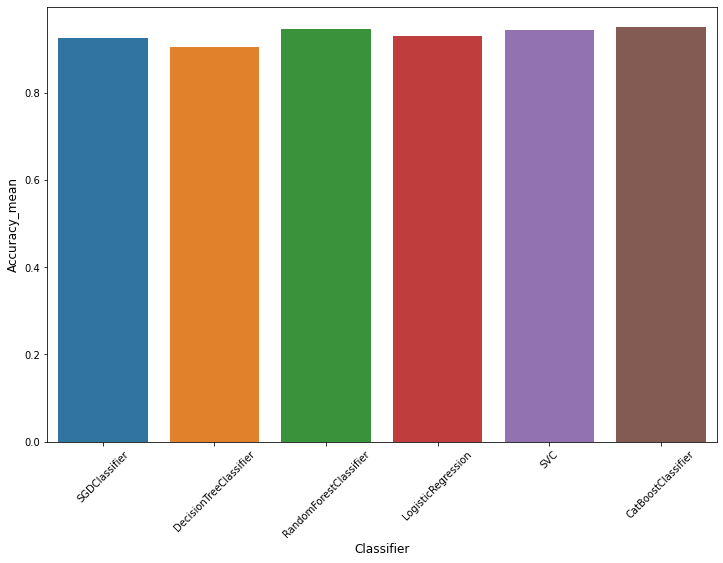

In [476]:
plt.figure(figsize = (12,8))
sns.barplot(final_cv_score['Classifier'],final_cv_score['Accuracy_mean'])
plt.xlabel('Classifier', fontsize = 12)
plt.ylabel('Accuracy_mean', fontsize = 12)
plt.xticks(rotation=45)
plt.show()

In [ ]:
cat = CatBoostClassifier()
cat_model = cat.fit(df_train, target_train,
                     eval_set = (df_valid, target_valid))

In [482]:
cat_pred = cat_model.predict(df_valid)
cat_score = accuracy_score(target_valid, cat_pred)
cat_score

0.947

In [ ]:
grid = {'iterations': [1000, 2000, 6000],
        'learning_rate': [0.05, 0.005, 0.0005],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 9]}

final_model = CatBoostClassifier()
randomized_search_result = final_model.randomized_search(grid,
                                                   X = df_train,
                                                   y= target_train,
                                                   verbose = False)
                                                   

In [487]:
randomized_search_result['params']

{'depth': 6, 'l2_leaf_reg': 5, 'iterations': 2000, 'learning_rate': 0.05}

In [ ]:
final_model = CatBoostClassifier(**randomized_search_result['params'])
final_model = final_model.fit(df_train, target_train)
final_pred = final_model.predict(df_valid)
final_score = accuracy_score(target_valid, final_pred)

In [494]:
final_score

0.94925

## DENOISING

In [2]:
MAX_LENGTH = 500
MEL_HEIGHT = 80

In [3]:
#приведение numpy матриц к одному размеру
def identical_matrix(arr, pad_len=MAX_LENGTH):
    l = len(arr)
    if l == pad_len:
        return arr
    if l > pad_len:
        idx = np.random.randint(0, l - pad_len)
        return arr[idx:idx+pad_len, :]
    else:
        arr = np.concatenate((arr, arr), axis=0)
        return identical_matrix(arr, pad_len)

In [4]:
#функция для распаковки матриц
def get_dataframe(name):
    
    # name = './' + name + '/'
    dataframe_clean, tmp_clean = np.array([]), np.array([])
    dataframe_noisy, tmp_noisy = np.array([]), np.array([])
    iterator = 0
    clean_path = os.path.join(name, 'clean/')
    noisy_path = os.path.join(name, 'noisy/')
    persons_talking = os.listdir(noisy_path)
    person_clean__path, person_noisy_path = '', ''

    for customer in persons_talking:
        customer_data_clean = np.array([])
        customer_data_noisy = np.array([])
        person_clean__path = str(os.path.join(clean_path, customer))
        person_noisy_path = str(os.path.join(noisy_path, customer))
        audiofiles = os.listdir(person_clean__path)

        for audio in audiofiles:
            clean_rec = np.load(person_clean__path + '/' + audio)
            noisy_rec = np.load(person_noisy_path + '/' + audio)
            clean_rec = identical_matrix(clean_rec)
            noisy_rec = identical_matrix(noisy_rec)
            customer_data_clean = np.append(customer_data_clean, clean_rec)
            customer_data_noisy = np.append(customer_data_noisy, noisy_rec)

        tmp_clean = np.append(tmp_clean, customer_data_clean)
        tmp_noisy = np.append(tmp_noisy, customer_data_noisy)
        
        
        if iterator % 100 == 0 and iterator != 0:
            dataframe_clean = np.append(dataframe_clean, tmp_clean)
            dataframe_noisy = np.append(dataframe_noisy, tmp_noisy)
            tmp_clean = np.array([])
            tmp_noisy = np.array([])
        iterator += 1
    if tmp_clean.size != 0:
        dataframe_clean = np.append(dataframe_clean, tmp_clean)
        dataframe_noisy = np.append(dataframe_noisy, tmp_noisy)
    dataframe_clean = dataframe_clean.reshape(-1, MAX_LENGTH, MEL_HEIGHT, 1)
    dataframe_noisy = dataframe_noisy.reshape(-1, MAX_LENGTH, MEL_HEIGHT, 1)
    return dataframe_clean, dataframe_noisy

In [5]:
data_clean, data_noisy = get_dataframe('/Users/denissinickij/Downloads/test_task/train/train')

In [6]:
data_clean.shape

(12000, 500, 80, 1)

In [8]:
type(data_noisy)

numpy.ndarray

In [9]:
data_clean = torch.from_numpy(data_clean)
data_noisy = torch.from_numpy(data_noisy)

In [11]:
import torch.nn as nn
from torchsummary import summary

In [28]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder 
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.LazyBatchNorm2d(),
            nn.SELU()
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding=1),
            nn.LazyBatchNorm2d(),
            nn.SELU()
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 4, kernel_size=3, padding=1),
            nn.LazyBatchNorm2d(),
            nn.SELU()
            )

        self.pool = nn.MaxPool2d(2, 2)
        
        #decoder
        self.conv1_t = nn.Sequential(
            nn.ConvTranspose2d(4, 16, kernel_size=3, stride=2, padding=0),
            nn.LazyBatchNorm2d(),
            nn.SELU()
            )
        self.conv2_t = nn.Sequential(
            nn.ConvTranspose2d(16, 4, kernel_size=3, stride=1, padding=0),
            nn.LazyBatchNorm2d(),
            nn.SELU()
            )
        self.conv3_t = nn.Sequential(
            nn.Conv2d(4, 1, kernel_size=4, stride=1, padding=0),
            nn.LazyBatchNorm2d(),
            nn.SELU()
            )

        

    def forward(self, x):
        # encode
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool(x) # ⟸ bottleneck
        
        # decode
        x = self.conv1_t(x)
        x = self.conv2_t(x)
        x = self.conv3_t(x)

        return x


model = ConvAutoencoder()
summary(model, (1, MAX_LENGTH, MEL_HEIGHT))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 500, 80]             320
       BatchNorm2d-2          [-1, 32, 500, 80]              64
              SELU-3          [-1, 32, 500, 80]               0
            Conv2d-4          [-1, 16, 500, 80]           4,624
       BatchNorm2d-5          [-1, 16, 500, 80]              32
              SELU-6          [-1, 16, 500, 80]               0
            Conv2d-7           [-1, 4, 500, 80]             580
       BatchNorm2d-8           [-1, 4, 500, 80]               8
              SELU-9           [-1, 4, 500, 80]               0
        MaxPool2d-10           [-1, 4, 250, 40]               0
  ConvTranspose2d-11          [-1, 16, 501, 81]             592
      BatchNorm2d-12          [-1, 16, 501, 81]              32
             SELU-13          [-1, 16, 501, 81]               0
  ConvTranspose2d-14           [-1, 4, 

In [13]:
criterion = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.9)

lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.05)

optimizer.param_groups[0]["lr"]

0.9

In [48]:
trainset = torch.utils.data.TensorDataset(torch.permute(data_noisy, (0, 3, 1, 2)).float())
trainset_clean = torch.utils.data.TensorDataset(torch.permute(data_clean, (0, 3, 1, 2)).float())

In [24]:
torch.permute(data_noisy, (0, 3, 1, 2)).shape

torch.Size([12000, 1, 500, 80])

In [49]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=False, drop_last=True)
clean_loader = torch.utils.data.DataLoader(trainset_clean, batch_size=50, shuffle=False, drop_last=True)

In [ ]:
n_epochs = 20
train_loss=[]
lrs = []
model.float()
for epoch in range(1, n_epochs+1):

    train_loss_batch = 0.0
    
    for i, (dirty, clean) in enumerate(zip(train_loader, clean_loader)):
        audio = dirty[0]
        optimizer.zero_grad()
        outputs = model(audio)
        loss = criterion(outputs, clean[0])
        loss.backward()
        optimizer.step()
        lr_sched.step()
        train_loss_batch += loss.item()*audio.size(0)
    train_loss.append(train_loss_batch/len(train_loader))
    if epoch % 1 == 0:
        lrs.append(optimizer.param_groups[0]["lr"])
        print(f'Epoch: {epoch} \tTraining Loss: {train_loss_batch:.6f} \tlr:{optimizer.param_groups[0]["lr"]}')
